In [22]:
import obspy
from obspy.clients.fdsn import Client
import numpy as np
import matplotlib.pyplot as plt

client = Client("IRIS")

## Importing real data

In [23]:
# Import earthquake data
start_time = obspy.UTCDateTime("2013-05-24T05:44:48")  # Replace with the start time of the earthquake
end_time = obspy.UTCDateTime("2013-05-24T05:44:50")  # Replace with the end time of the earthquake
event = client.get_events(starttime=start_time, endtime=end_time, minmagnitude=8.3)
# Import station data
inventory = client.get_stations(network="BK", station="CMB", channel="BH*", location='00', level="response")
# Import wavefield data
real_data = obspy.read('data/2013-05-24-mw83-sea-of-okhotsk.miniseed')

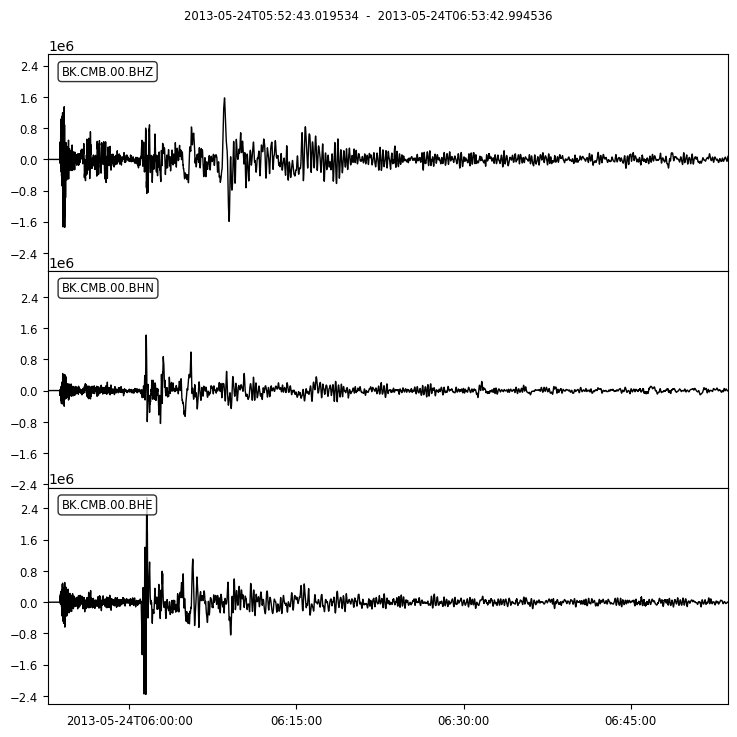

In [25]:
# Select specific station
selected_stream = real_data.select(station='CMB')
selected_stream.plot()
plt.show()

<Figure size 640x480 with 0 Axes>

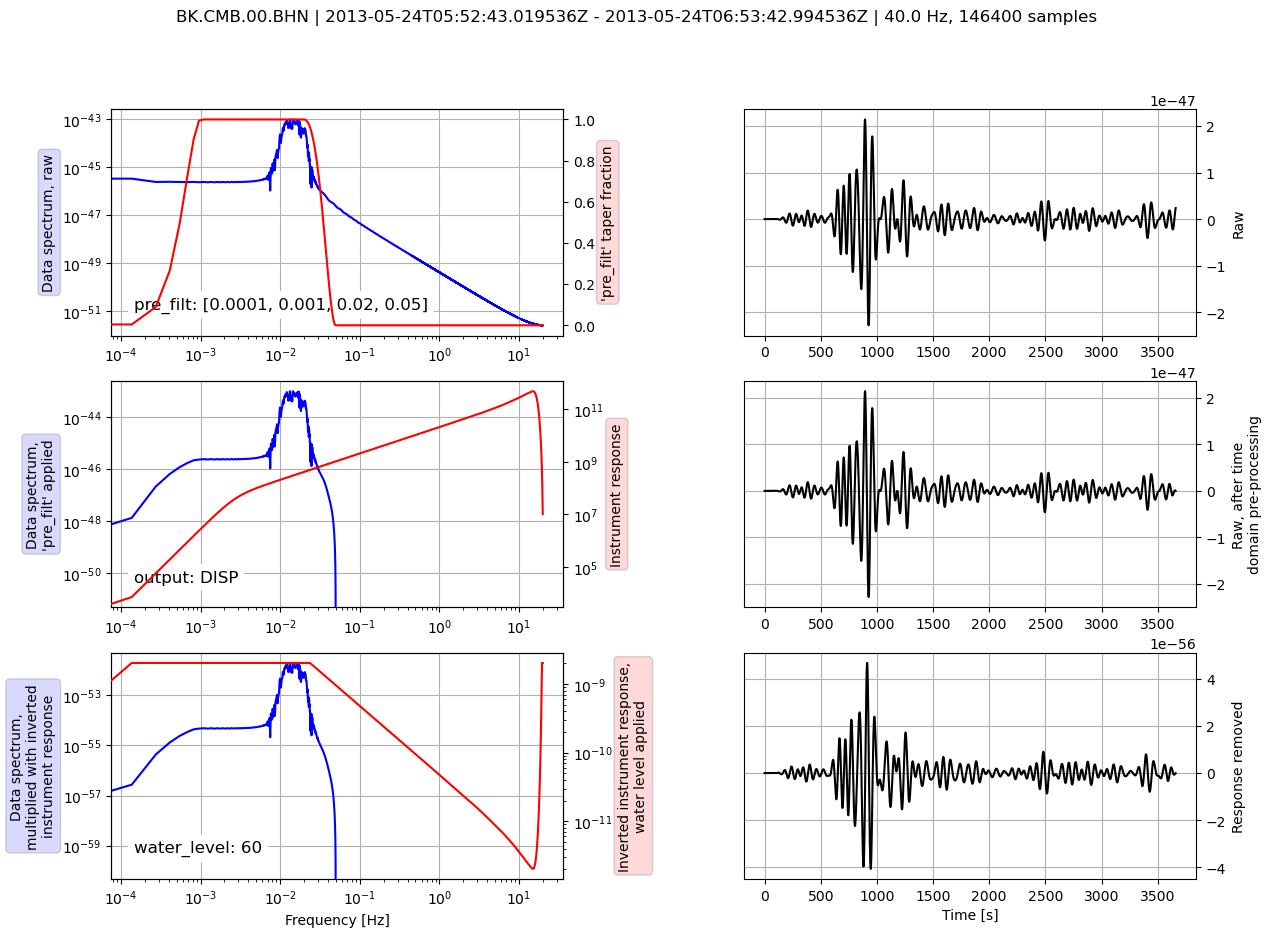

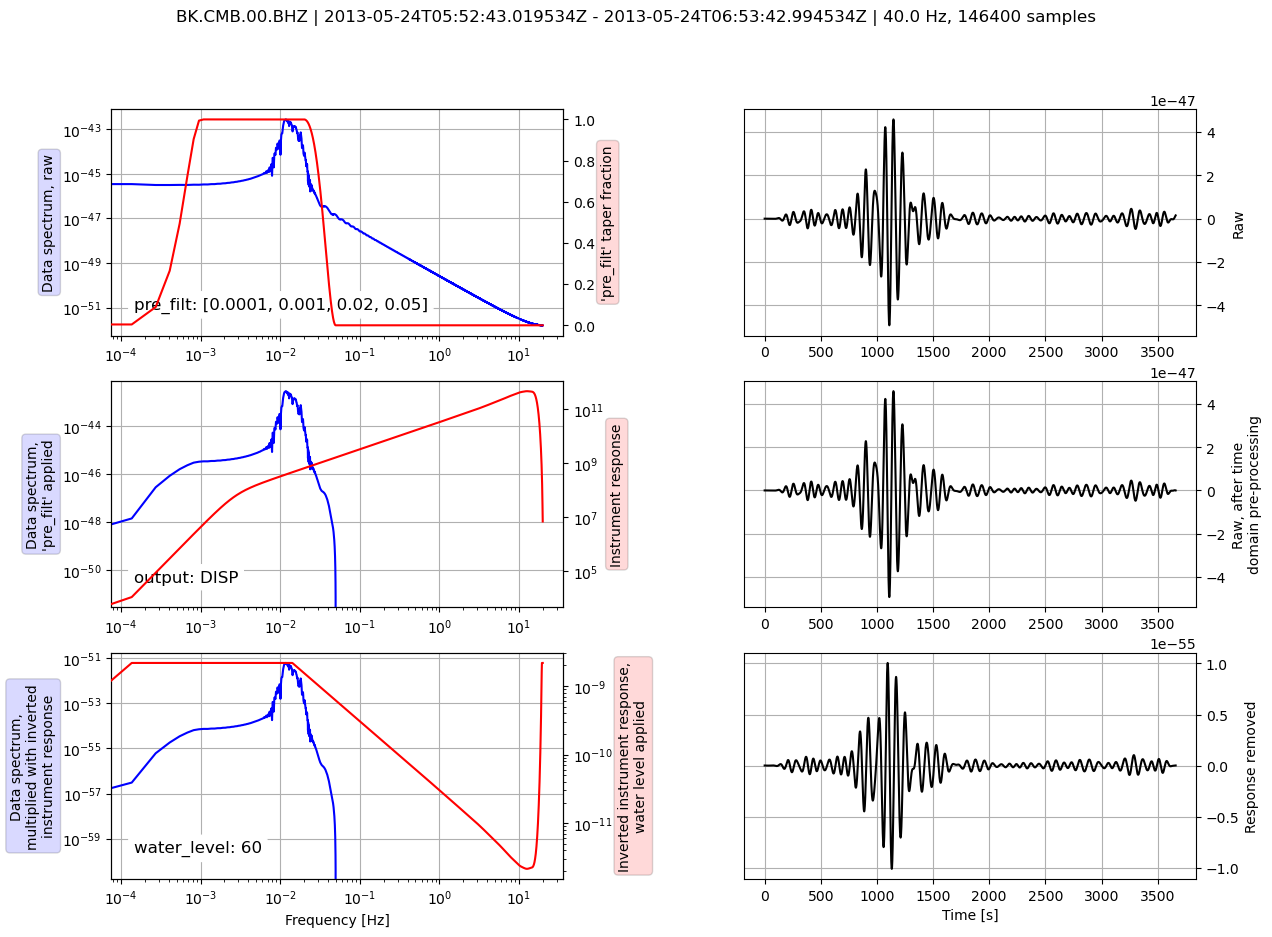

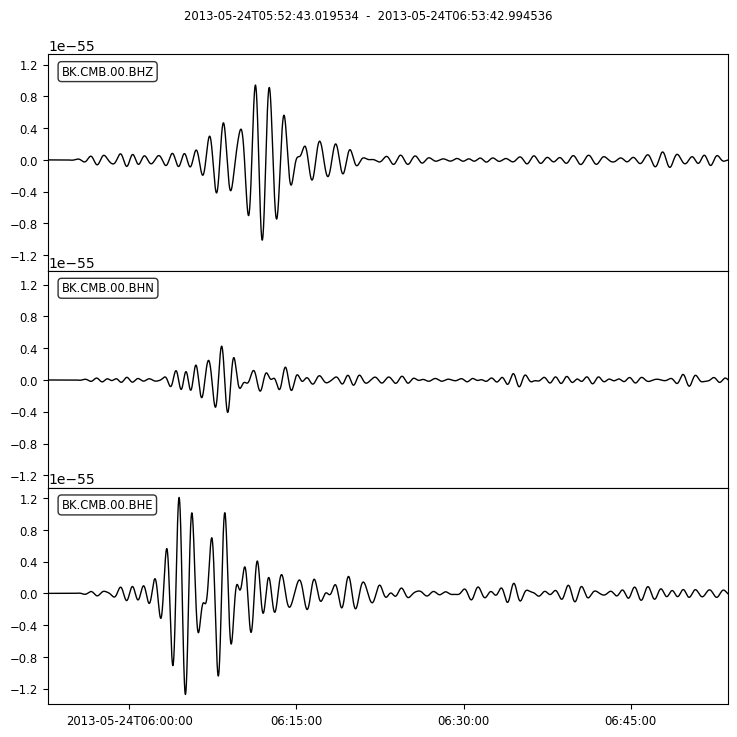

In [33]:
# Process the station to match the period of the synthetic data
selected_stream.remove_response(inventory=inventory,
                                pre_filt=[1e-4, 1e-3, 0.02, 0.05],
                                output="DISP", water_level=60,
                                plot=True)
selected_stream.detrend()
selected_stream.filter('bandpass', freqmin=0.001, freqmax=0.02)
selected_stream.plot()
plt.show()

## Reproducing the earthquake